# **CNN + BLSTM MODEL**

**IMPORT PACKAGES AND LIBRARIES**

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from nltk import word_tokenize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**LOAD DATASET**

In [ ]:
data=pd.read_csv('sp_translated.csv')

In [ ]:
data

,Unnamed: 0,Fake,final_clean
0,0,0,intentar prender fuego espós ilesa gravemente ...
1,1,0,ese ser renaud vuelta escenario octubre acción...
2,2,0,traje rojo qué mensaje querer enviar hillary c...
3,3,0,footligar resultado octava jornada h octubre m...
4,4,0,suscríbete podcast poder suscribir él descarga...
...,...,...,...
2009,500,1,ministro salud agn buzyn pourt edad profesor g...
2010,501,1,asociación londres lucha contaminación transpo...
2011,502,1,psicólogo demostrar efecto beneficioso pérdida...
2012,503,1,ministro interior harto ver policía gendarme h...


In [ ]:
data['Fake'].value_counts()

0    1509
1     505
Name: Fake, dtype: int64

In [ ]:
docs = data.final_clean.values
labels = data.Fake.values

In [ ]:
from collections import Counter
Counter(labels)

Counter({0: 1509, 1: 505})

**TOKENIZATION**

In [ ]:
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1  # I add one because it starts counting from 0

In [ ]:
import nltk  # don't forget to do this step everytime in colab
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data['Text_tokenised'] = data['final_clean'].apply(word_tokenize)

In [ ]:
data.head()

,Unnamed: 0,Fake,final_clean,Text_tokenised
0,0,0,intentar prender fuego espós ilesa gravemente ...,"[intentar, prender, fuego, espós, ilesa, grave..."
1,1,0,ese ser renaud vuelta escenario octubre acción...,"[ese, ser, renaud, vuelta, escenario, octubre,..."
2,2,0,traje rojo qué mensaje querer enviar hillary c...,"[traje, rojo, qué, mensaje, querer, enviar, hi..."
3,3,0,footligar resultado octava jornada h octubre m...,"[footligar, resultado, octava, jornada, h, oct..."
4,4,0,suscríbete podcast poder suscribir él descarga...,"[suscríbete, podcast, poder, suscribir, él, de..."


In [ ]:
data['length'] = data['Text_tokenised'].str.len()

In [ ]:
maxlen = data['length'].max()

In [ ]:
maxlen

2806

**SPLIT DATA INTO TRAIN AND VALIDATE SETS**

In [ ]:
# divide the data into train/validate

from sklearn.model_selection import train_test_split


sentences_train, sentences_valid, y_train, y_valid = train_test_split(
    docs, labels, test_size=0.2, random_state=1000)

In [ ]:
Counter(labels)

Counter({0: 1509, 1: 505})

**CONVERT TEXTS TO SEQUENCES**

In [ ]:
# use keras tokenizer to turn train and valid to sequence


X_train = t.texts_to_sequences(sentences_train)
X_valid = t.texts_to_sequences(sentences_valid)


print(sentences_train[2])
print(X_train[2])

vieill charru montar carpa césped central park music celebrar aniversario festival organizar velado sábado nuevo york audiencia vieill charru aquí julio motivo aniversario festival alain robert sipar jérôme gicquel pradera kerampuilh carhaix prado central park nueva york celebrar estilo edición festival equipo vieill charrues dar paso velado organizado nuevo york sábado jerome trehorel jerometrehorel septiembre seducir público estadounidense festival bretón llevar maleta cantante m habitual praderar kerampuilh nizar dj the avener así dos grupo local celtic social club dúo krismenn alem mezcla beatbox canción tradicional bretona bretón hacer viaje loca idea organizar noche plowshar nuevo york nacer reunión mayo equipo festival bzh new york asociación británicos gran manzana por invitación él nuevo york presentar vieill charru parte fête bretagne festival especie historio éxito estadounidense pequeño fiesta organizado amigo corazón bretaña convertido año festival importante europa explic

**APPLY POST-PADDING**

In [ ]:
# pad the short sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)

print(X_train[1, :])

[1854 1069  551 ...    0    0    0]


**EMBEDDING MATRIX**

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

**LOAD PRE-TRAINED WORD EMBEDDINGS**

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
        '/content/drive/MyDrive/thesiss/embeddings-l-model.vec',
        t.word_index, embedding_dim)

In [ ]:
# how many of the embedding vectors are nonzero

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7747782491322792

# **MODEL: CNN + BLSTM**

**BUILD THE MODEL**

In [ ]:
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from keras.regularizers import l2

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam=Adam(learning_rate=0.0001) 
model.compile(optimizer=adam, 
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 2806, 300)         10112700  
                                                                 
 dropout_12 (Dropout)        (None, 2806, 300)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2805, 64)          38464     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 701, 64)          0         
 1D)                                                             
                                                                 
 bidirectional_8 (Bidirectio  (None, 701, 80)          33600     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 80)              

**TRAIN THE MODEL**

In [ ]:
Counter(y_train)

Counter({0: 1207, 1: 404})

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=32)

Epoch 1/20
51/51 [==============================] - 13s 154ms/step - loss: 1.1123 - accuracy: 0.7486 - val_loss: 1.0500 - val_accuracy: 0.7494
Epoch 2/20
51/51 [==============================] - 7s 131ms/step - loss: 0.9931 - accuracy: 0.7492 - val_loss: 0.9521 - val_accuracy: 0.7494
Epoch 3/20
51/51 [==============================] - 7s 132ms/step - loss: 0.9109 - accuracy: 0.7492 - val_loss: 0.8461 - val_accuracy: 0.7494
Epoch 4/20
51/51 [==============================] - 7s 132ms/step - loss: 0.7140 - accuracy: 0.7759 - val_loss: 0.6346 - val_accuracy: 0.9032
Epoch 5/20
51/51 [==============================] - 7s 133ms/step - loss: 0.5501 - accuracy: 0.9721 - val_loss: 0.6004 - val_accuracy: 0.9429
Epoch 6/20
51/51 [==============================] - 7s 134ms/step - loss: 0.4872 - accuracy: 0.9739 - val_loss: 0.4667 - val_accuracy: 0.9553
Epoch 7/20
51/51 [==============================] - 7s 135ms/step - loss: 0.4002 - accuracy: 0.9919 - val_loss: 0.4735 - val_accuracy: 0.9653
Epoch

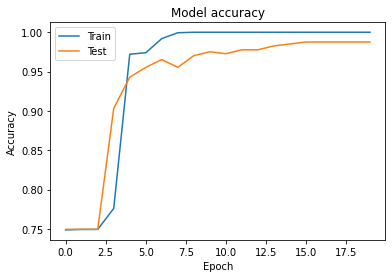

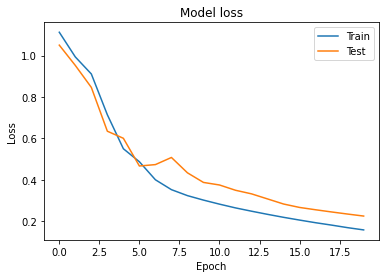

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

**GRAPHIC REPRESENTATION**

In [ ]:
Counter(y_train[:1000])

Counter({0: 509, 1: 491})

**METRICS**

In [ ]:
y_pred_valid=(model.predict(X_valid)>0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid,y_pred_valid))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       302
           1       0.99      0.96      0.97       101

    accuracy                           0.99       403
   macro avg       0.99      0.98      0.98       403
weighted avg       0.99      0.99      0.99       403



In [ ]:
confusion_matrix(y_valid,y_pred_valid)

array([[301,   1],
       [  4,  97]])